In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

triads = [['BPS'+str(i),'BPS'+str(i+20),'BPS'+str(i+40)] for i in range(1,21)]
pd.options.display.max_columns= 79

In [2]:
#import datafile

df = pd.read_csv('new_test/20TH jUNE 24HOUR DATA.csv')

In [3]:
#define algos and parameters

def check_hf_flag(y1, y2, lag_w, lag_cs, lag_sd):
   
    #initialize arrays for signals(peaks/dips), filtered output(smoothened), avgfilter(mean), stdfilter(std dev)
    signals = np.zeros(len(y1))
    pos= np.zeros(len(y1))  # 10 for right, 300 for left, arbritrary
    
    filtered_y1 = np.array(y1)
    filtered_y2 = np.array(y2)
    
    avgFilter_y1 = [0]*len(y1)
    avgFilter_y2 = [0]*len(y2)
    
    stdFilter_y1 = [0]*len(y1)
    stdFilter_y2 = [0]*len(y2)
    
    
    #calculate mean of moving window
    avgFilter_y1[lag_time - 1] = np.mean(y1[lag_time-lag_w:lag_time])
    avgFilter_y2[lag_time - 1] = np.mean(y2[lag_time-lag_w:lag_time])
    
    stdFilter_y1[lag_time - 1] = np.std(y1[lag_time- lag_sd:lag_time])
    stdFilter_y2[lag_time - 1] = np.std(y2[lag_time- lag_sd:lag_time])
    
    
    
    #run the moving window over input signal. Skips first n points. (n=lag)
    for i in range(lag_w, len(y1)):
        
        
        if i > (lag_time + 1):
            
            cs_max= df['CAST_SPEED_ACT'][i-lag_cs:i-1].max()
            cs_min= df['CAST_SPEED_ACT'][i-lag_cs:i-1].min()
            cs_act=df['CAST_SPEED_ACT'].iloc[i]
            
            # casting speed minimum change condition check
            
            if cs_act >= 4.5:
            
                if ((abs(cs_act-cs_min)<=0.1) and (abs(cs_max-cs_act)<=0.1)):

                    right_status = ((avgFilter_y1[i-1] - stdFilter_y1[i-1]) -  df['HF_RIGHT'][i]) 
                    left_status = ((avgFilter_y2[i-1] - stdFilter_y2[i-1]) -  df['HF_LEFT'][i])

                    if (right_status > 0.15 and left_status <= 0.15) or (left_status > 0.15 and right_status <= 0.15):

                        #check if signals not in last 5 mins
                            if -1 not in signals[i-lag_time:i]:

                                signals[i] = -1

                                if (right_status > 0.15 and left_status <= 0.15):
                                    pos[i]=10 # hf_right
                                else:
                                    pos[i]=300 #hf_left
                
                        
            #output filtered signal with smoothened peak/dip
            filtered_y1[i] = y1[i]
            filtered_y2[i] = y2[i]
            
            #calculate mean for next step of moving window
            avgFilter_y1[i] = np.mean(filtered_y1[(i-lag_w+1):i+1])
            avgFilter_y2[i] = np.mean(filtered_y2[(i-lag_w+1):i+1])
            
            stdFilter_y1[i] =  np.std(filtered_y1[(i-lag_sd+1):i+1])
            stdFilter_y2[i] =  np.std(filtered_y2[(i-lag_sd+1):i+1])
            
           
        else:
            signals[i] = 0
            filtered_y1[i] = y1[i]
            filtered_y2[i] = y2[i]
            avgFilter_y1[i] = np.mean(filtered_y1[(i-lag_w+1):i+1])
            avgFilter_y2[i] = np.mean(filtered_y2[(i-lag_w+1):i+1])
            stdFilter_y1[i] =  np.std(filtered_y1[(i-lag_sd+1):i+1])
            stdFilter_y2[i] =  np.std(filtered_y2[(i-lag_sd+1):i+1])
            

    return dict(signals = np.asarray(signals), pos= np.asarray(pos),
                avgFilter_y1 = np.asarray(avgFilter_y1), stdFilter_y1=np.asarray(stdFilter_y1), avgFilter_y2 = np.asarray(avgFilter_y2), stdFilter_y2=np.asarray(stdFilter_y2) )


'''
moving window over 30 data points,
signals peaks/valleys if data point exceeds 3.5 std. deviation of moving mean
signals get 0.2 value of regular points for calculating moving mean
'''

lag_w = 45 ## 90 sec for average
lag_cs= 65 # 130 sec
lag_sd = 5 # 10 sec for std dev
lag_time =150 # for 5 min



y1= df['HF_RIGHT'].to_numpy()
y2= df['HF_LEFT'].to_numpy()

result1 = check_hf_flag(y1,y2, lag_w=lag_w, lag_cs= lag_cs, lag_sd=lag_sd)

#store dips of each thermocouple
locations1=[]
for i in range(len(result1['signals'])):
    if result1['signals'][i] == -1.0:
        if result1['pos'][i] == 10:
            locations1.append([i,'HF_RIGHT'])
        else:
            locations1.append([i,'HF_LEFT'])
            

result_set= locations1


print(str(result_set))

[[17973, 'HF_LEFT'], [43952, 'HF_LEFT']]


In [4]:
#store dip points

df_val1=pd.DataFrame(columns=['Index','Time','Met_length', 'Algo', 'Heat_Flux', "HF_Value"])
#df_val1=pd.DataFrame(columns=['Index','Time','Triad', 'Type', 'Algo' , 'Name'])
counter=0

for j in range(len(result_set)):
    result=(result_set[j][0])
    result_hf = str(result_set[j][1])
    result_value= df.iloc[result][result_hf]
    df_val1.loc[counter]=pd.Series({'Index':result, 'Time':df.iloc[result]['TIME_STAMP'], 'Met_length':str(df.iloc[result]['MET_LENGTH']),'Algo': 'BO_Algo New', 'Heat_Flux': result_hf,'HF_Value': result_value  })
    #df_val1.loc[counter]=pd.Series({'Index':result, 'Time':df.iloc[result]['TIME_STAMP'], 'Triad':triads[i], 'Type':'Wide','Algo': 'Z-Score', 'Name': " ".join(triads[i])})
    counter=counter+1
        

c1_wide=df_val1.sort_values(by='Index', ascending=True)
print('-'*100)
print(' '*35+ 'Dips through Z-Score')
print('-'*100)
#c1_wide=c1_wide[~((c1_wide['Name'].str.contains('BPS11')) | (c1_wide['Name'].str.contains('BPS1 '))| (c1_wide['Name'].str.contains('BPS12')) | (c1_wide['Name'].str.contains('BPS2 ')) | (c1_wide['Name'].str.contains('BPS20')) | (c1_wide['Name'].str.contains('BPS10')) | (c1_wide['Name'].str.contains('BPS3 ')))]
#c1_wide=c1_wide.drop(columns=['Name'])
#c1_wide.loc[1]=pd.Series(c1_wide.loc[0])
c1_wide

----------------------------------------------------------------------------------------------------
                                   Dips through Z-Score
----------------------------------------------------------------------------------------------------


,Index,Time,Met_length,Algo,Heat_Flux,HF_Value
0,17973,20-06-22 02:49:06,6488.187,BO_Algo New,HF_LEFT,1.995
1,43952,20-06-22 17:10:13,7521.606,BO_Algo New,HF_LEFT,2.421


In [ ]:
'''only run this cell if result has only single row.
so as to duplicate the row twice.
as plot function doesn't run on single rows but only on mupltiple rows''' 

#c1_wide.loc[1]=pd.Series(c1_wide.loc[0])
#c1_wide

No handles with labels found to put in legend.
No handles with labels found to put in legend.


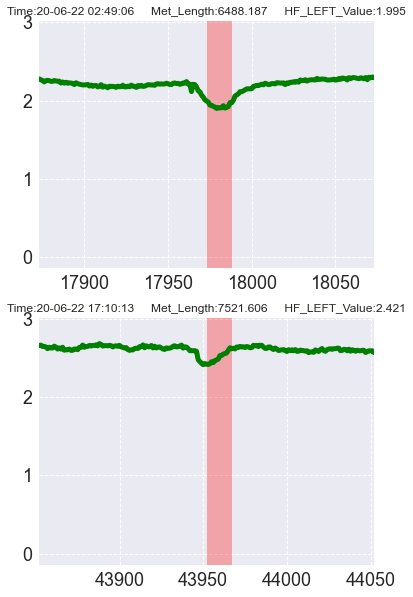

In [5]:
#plot function

#plotting detected dips

plt.style.use("seaborn")

fig, axs = plt.subplots(len(c1_wide), figsize=(6, 5*len(c1_wide)))
for i in range(len(c1_wide)):
    Title= str('Time:'+c1_wide.iloc[i]['Time'])+'     Met_Length:'+str(c1_wide.iloc[i]['Met_length'])+'     '+ str(c1_wide.iloc[i]['Heat_Flux'])+'_Value:'+ str(c1_wide.iloc[i]['HF_Value'])
    det= int(c1_wide.iloc[i]['Index'])
    axs[i].plot(df[c1_wide.iloc[i]['Heat_Flux']], linewidth=5, color='green', linestyle='solid')
    axs[i].axvspan(det,det+15, facecolor='r', alpha=0.3)
    axs[i].set_title(Title)
    axs[i].tick_params(axis='both', labelsize=18)
    axs[i].legend(fontsize=16, loc='center right')
    axs[i].grid(axis = 'both', linestyle='--')
    axs[i].set_xlim(det-100,det+100)
plt.show()

In [ ]:
#save dip points as csv file

c1_wide.to_csv('dump/bo_new_result.csv')